In [ ]:
!mkdir stocks && cd stocks

mkdir: cannot create directory ‘stocks’: File exists


In [ ]:
url = 'https://raw.githubusercontent.com/sryza/aas/master/ch09-risk/data/stocks.zip'
!wget $url
!unzip stocks.zip

--2024-06-07 12:46:18--  https://raw.githubusercontent.com/sryza/aas/master/ch09-risk/data/stocks.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71905265 (69M) [application/zip]
Saving to: ‘stocks.zip’

stocks.zip          100%[===================>]  68.57M   220MB/s    in 0.3s    

2024-06-07 12:46:18 (220 MB/s) - ‘stocks.zip’ saved [71905265/71905265]

Archive:  stocks.zip
  inflating: stocks/AAIT.csv         
  inflating: stocks/AAL.csv          
  inflating: stocks/AAME.csv         
  inflating: stocks/AAOI.csv         
  inflating: stocks/AAON.csv         
  inflating: stocks/AAPL.csv         
 extracting: stocks/AAVL.csv         
  inflating: stocks/AAWW.csv         
  inflating: stocks/AAXJ.csv         
  inflating: stocks/ABAC.csv         
  inf

In [ ]:
!cd .. && mkdir factors && cd factors
url2 = "https://raw.githubusercontent.com/sryza/aas/master/ch09-risk/data/factors.zip"
!wget $url2
!unzip factors.zip
!ls factors

--2024-06-07 12:36:24--  https://raw.githubusercontent.com/sryza/aas/master/ch09-risk/data/factors.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102896 (100K) [application/zip]
Saving to: ‘factors.zip’

factors.zip         100%[===================>] 100.48K  --.-KB/s    in 0.02s   

2024-06-07 12:36:24 (4.00 MB/s) - ‘factors.zip’ saved [102896/102896]

Archive:  factors.zip
  inflating: factors/NASDAQ%3ATLT.csv  
  inflating: factors/NYSEARCA%3AGLD.csv  
  inflating: factors/NYSEARCA%3ACRED.csv  
NASDAQ%3ATLT.csv  NYSEARCA%3ACRED.csv  NYSEARCA%3AGLD.csv


In [ ]:
!head -n 5 factors/NASDAQ%3ATLT.csv

﻿Date,Open,High,Low,Close,Volume
31-Dec-13,102.29,102.55,101.17,101.86,7219195
30-Dec-13,102.15,102.58,102.08,102.51,4491711
27-Dec-13,102.07,102.31,101.69,101.81,4755262
26-Dec-13,102.35,102.36,102.01,102.10,4645323


# Creating the Spark Environment

In [ ]:
!pip install pyspark
import pyspark

from pyspark.sql import SparkSession

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=69302061ce188982b8b3843789f13aeeea449e8ab75be9361a77d8bbf99b92fd
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
spark = SparkSession.builder.config("spark.driver.memory", "8g").appName('chapter_8').getOrCreate()

# Preparing the Data

In [ ]:
!head -n 5 stocks/GOOGL.csv

﻿Date,Open,High,Low,Close,Volume
31-Dec-13,556.68,561.06,553.68,560.92,1358300
30-Dec-13,560.73,560.81,555.06,555.28,1236709
27-Dec-13,560.56,560.70,557.03,559.76,1570140
26-Dec-13,557.56,560.06,554.90,559.29,1338507


In [ ]:
stocks = spark.read.csv("stocks/", header='true', inferSchema='true')

stocks.show(2, truncate=False, vertical=True)

-RECORD 0-----------
 Date   | 31-Dec-13 
 Open   | 1884.00   
 High   | 1900.00   
 Low    | 1880.00   
 Close  | 1900.0    
 Volume | 546       
-RECORD 1-----------
 Date   | 30-Dec-13 
 Open   | 1889.00   
 High   | 1900.00   
 Low    | 1880.00   
 Close  | 1900.0    
 Volume | 1656      
only showing top 2 rows



In [ ]:
from pyspark.sql import functions as fun

stocks = stocks.withColumn("Symbol", fun.input_file_name()).\
                withColumn("Symbol",
                  fun.element_at(fun.split("Symbol", "/"), -1)).\
                withColumn("Symbol",
                  fun.element_at(fun.split("Symbol", "\."), 1))

stocks.show(2)

+---------+-------+-------+-------+------+------+------+
|     Date|   Open|   High|    Low| Close|Volume|Symbol|
+---------+-------+-------+-------+------+------+------+
|31-Dec-13|1884.00|1900.00|1880.00|1900.0|   546|  CLDN|
|30-Dec-13|1889.00|1900.00|1880.00|1900.0|  1656|  CLDN|
+---------+-------+-------+-------+------+------+------+
only showing top 2 rows



In [ ]:
factors = spark.read.csv("factors", header='true', inferSchema='true')
factors = factors.withColumn("Symbol", fun.input_file_name()).\
                  withColumn("Symbol",
                    fun.element_at(fun.split("Symbol", "/"), -1)).\
                  withColumn("Symbol",
                    fun.element_at(fun.split("Symbol", "\."), 1))

In [ ]:
from pyspark.sql import Window

stocks = stocks.withColumn('count', fun.count('Symbol').\
                over(Window.partitionBy('Symbol'))).\
                filter(fun.col('count') > 260*5 + 10)

In [ ]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [ ]:
stocks = stocks.withColumn('Date',
                  fun.to_date(fun.to_timestamp(fun.col('Date'),
                                              'dd-MMM-yy')))
stocks.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- count: long (nullable = false)



In [ ]:
from datetime import datetime

stocks = stocks.filter(fun.col('Date') >= datetime(2009, 10, 23)).\
                filter(fun.col('Date') <= datetime(2014, 10, 23))

In [ ]:
factors = factors.withColumn('Date',
                              fun.to_date(fun.to_timestamp(fun.col('Date'),
                                                          'dd-MMM-yy')))

factors = factors.filter(fun.col('Date') >= datetime(2009, 10, 23)).\
                  filter(fun.col('Date') <= datetime(2014, 10, 23))

In [ ]:
stocks_pd_df = stocks.toPandas()
factors_pd_df = factors.toPandas()

factors_pd_df.head(5)

,Date,Open,High,Low,Close,Volume,Symbol
0,2013-12-31,102.29,102.55,101.17,101.86,7219195,NASDAQ%253ATLT
1,2013-12-30,102.15,102.58,102.08,102.51,4491711,NASDAQ%253ATLT
2,2013-12-27,102.07,102.31,101.69,101.81,4755262,NASDAQ%253ATLT
3,2013-12-26,102.35,102.36,102.01,102.10,4645323,NASDAQ%253ATLT
4,2013-12-24,103.23,103.35,102.80,102.83,4897009,NASDAQ%253ATLT


# Determining the Factor Weights

In [ ]:
n_steps = 10


def my_fun(x):
    return ((x.iloc[-1] - x.iloc[0]) / x.iloc[0])

stock_returns = stocks_pd_df.groupby('Symbol').Close.\
                            rolling(window=n_steps).apply(my_fun)
factors_returns = factors_pd_df.groupby('Symbol').Close.\
                            rolling(window=n_steps).apply(my_fun)

stock_returns = stock_returns.reset_index().\
                              sort_values('level_1').\
                              reset_index()
factors_returns = factors_returns.reset_index().\
                                  sort_values('level_1').\
                                  reset_index()

In [ ]:
# Create combined stocks DF
stocks_pd_df_with_returns = stocks_pd_df.\
                              assign(stock_returns = \
                                    stock_returns['Close'])

# Create combined factors DF
factors_pd_df_with_returns = factors_pd_df.\
                              assign(factors_returns = \
                                    factors_returns['Close'],
                                    factors_returns_squared = \
                                    factors_returns['Close']**2)

factors_pd_df_with_returns = factors_pd_df_with_returns.\
                                pivot(index='Date',
                                      columns='Symbol',
                                      values=['factors_returns', \
                                              'factors_returns_squared'])

factors_pd_df_with_returns.columns = factors_pd_df_with_returns.\
                                        columns.\
                                        to_series().\
                                        str.\
                                        join('_').\
                                        reset_index()[0]

factors_pd_df_with_returns = factors_pd_df_with_returns.\
                                reset_index()

print(factors_pd_df_with_returns.head(1))

0        Date  factors_returns_NASDAQ%253ATLT  \
0  2009-10-23                         0.01834   

0  factors_returns_NYSEARCA%253ACRED  factors_returns_NYSEARCA%253AGLD  \
0                          -0.006594                         -0.032623   

0  factors_returns_squared_NASDAQ%253ATLT  \
0                                0.000336   

0  factors_returns_squared_NYSEARCA%253ACRED  \
0                                   0.000043   

0  factors_returns_squared_NYSEARCA%253AGLD  
0                                  0.001064  


In [ ]:
print(factors_pd_df_with_returns.columns)

Index(['Date', 'factors_returns_NASDAQ%253ATLT',
       'factors_returns_NYSEARCA%253ACRED', 'factors_returns_NYSEARCA%253AGLD',
       'factors_returns_squared_NASDAQ%253ATLT',
       'factors_returns_squared_NYSEARCA%253ACRED',
       'factors_returns_squared_NYSEARCA%253AGLD'],
      dtype='object', name=0)


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# For each stock, create input DF for linear regression training

stocks_factors_combined_df = pd.merge(stocks_pd_df_with_returns,
                                      factors_pd_df_with_returns,
                                      how="left", on="Date")

feature_columns = list(stocks_factors_combined_df.columns[-6:])

with pd.option_context('mode.use_inf_as_na', True):
    stocks_factors_combined_df = stocks_factors_combined_df.\
                                    dropna(subset=feature_columns \
                                            + ['stock_returns'])


def find_ols_coef(df):
    y = df[['stock_returns']].values
    X = df[feature_columns]

    regr = LinearRegression()
    regr_output = regr.fit(X, y)

    return list(df[['Symbol']].values[0]) + \
                list(regr_output.coef_[0])

coefs_per_stock = stocks_factors_combined_df.\
                      groupby('Symbol').\
                      apply(find_ols_coef)


coefs_per_stock = pd.DataFrame(coefs_per_stock).reset_index()
coefs_per_stock.columns = ['symbol', 'factor_coef_list']

coefs_per_stock = pd.DataFrame(coefs_per_stock.\
                                factor_coef_list.tolist(),
                                index=coefs_per_stock.index,
                                columns = ['Symbol'] + feature_columns)

coefs_per_stock

,Symbol,factors_returns_NASDAQ%253ATLT,factors_returns_NYSEARCA%253ACRED,factors_returns_NYSEARCA%253AGLD,factors_returns_squared_NASDAQ%253ATLT,factors_returns_squared_NYSEARCA%253ACRED,factors_returns_squared_NYSEARCA%253AGLD
0,AAME,-0.354006,-0.155522,0.060056,4.241884,-21.454728,1.712844
1,AAON,-1.317203,1.705401,-0.016400,5.547458,-14.897657,-1.059888
2,AAPL,-0.932688,1.318338,0.415743,0.079644,24.244610,-0.840677
3,AAWW,-2.043016,3.450677,0.410567,11.667825,-69.770385,-0.221532
4,AAXJ,-1.251594,2.352587,0.309533,4.528992,17.876991,-1.021739
...,...,...,...,...,...,...,...
1794,ZION,-1.894257,2.230450,-0.090260,8.845611,-26.945100,1.793449
1795,ZIOP,-2.035323,1.656815,0.939958,11.709497,14.681073,-10.747803
1796,ZIXI,-1.459298,1.732013,-0.153344,3.429339,-34.460048,1.905002
1797,ZUMZ,-1.890375,2.633159,-0.164973,8.295717,41.750435,-2.049881


# Sampling

<Axes: ylabel='Density'>

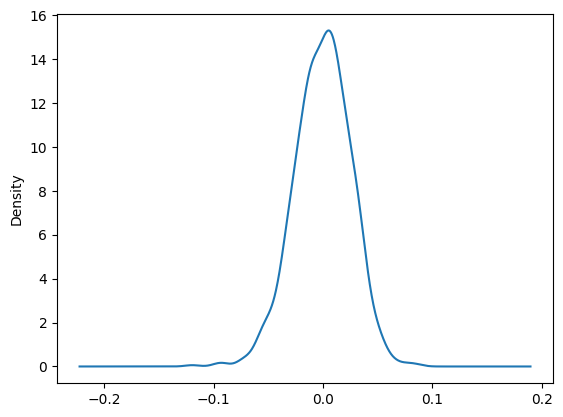

In [ ]:
samples = factors_returns.loc[factors_returns.Symbol == \
                              factors_returns.Symbol.unique()[0]]['Close']
samples.plot.kde()

In [ ]:
f_1 = factors_returns.loc[factors_returns.Symbol == \
                          factors_returns.Symbol.unique()[0]]['Close']
f_2 = factors_returns.loc[factors_returns.Symbol == \
                          factors_returns.Symbol.unique()[1]]['Close']
f_3 = factors_returns.loc[factors_returns.Symbol == \
                          factors_returns.Symbol.unique()[2]]['Close']

pd.DataFrame({'f1': list(f_1), 'f2': list(f_2)[:-2], 'f3': list(f_3)[:-1]}).corr()

,f1,f2,f3
f1,1.000000,0.074578,0.530550
f2,0.074578,1.000000,0.206538
f3,0.530550,0.206538,1.000000


In [ ]:
factors_returns_cov = pd.DataFrame({'f1': list(f_1),
                                    'f2': list(f_2[:-2]),
                                    'f3': list(f_3[:-1])})\
                                    .cov().to_numpy()
factors_returns_mean = pd.DataFrame({'f1': list(f_1),
                                     'f2': list(f_2[:-2]),
                                     'f3': list(f_3[:-1])}).\
                                     mean()

In [ ]:
from numpy.random import multivariate_normal

multivariate_normal(factors_returns_mean, factors_returns_cov)

array([0.02492127, 0.0169596 , 0.00117649])

# Running the Trials

In [ ]:
b_coefs_per_stock = spark.sparkContext.broadcast(coefs_per_stock)
b_feature_columns = spark.sparkContext.broadcast(feature_columns)
b_factors_returns_mean = spark.sparkContext.broadcast(factors_returns_mean)
b_factors_returns_cov = spark.sparkContext.broadcast(factors_returns_cov)

In [ ]:
from pyspark.sql.types import IntegerType

parallelism = 1000
num_trials = 1000000
base_seed = 1496

seeds = [b for b in range(base_seed,
                          base_seed + parallelism)]
seedsDF = spark.createDataFrame(seeds, IntegerType())

seedsDF = seedsDF.repartition(parallelism)

In [ ]:
import random
from numpy.random import seed

from pyspark.sql.types import LongType, ArrayType, DoubleType
from pyspark.sql.functions import udf


def calculate_trial_return(x):
#     return x
    trial_return_list = []

    for i in range(int(num_trials/parallelism)):
        random_int = random.randint(0, num_trials*num_trials)

        seed(x)

        random_factors = multivariate_normal(b_factors_returns_mean.value,
          b_factors_returns_cov.value)

        coefs_per_stock_df = b_coefs_per_stock.value
        returns_per_stock = (coefs_per_stock_df[b_feature_columns.value] *
          (list(random_factors) + list(random_factors**2)))

        trial_return_list.append(float(returns_per_stock.sum(axis=1).sum()/b_coefs_per_stock.value.size))

    return trial_return_list

udf_return = udf(calculate_trial_return, ArrayType(DoubleType()))

In [ ]:
from pyspark.sql.functions import col, explode

trials = seedsDF.withColumn("trial_return", udf_return(col("value")))
trials = trials.select('value', explode('trial_return').alias('trial_return'))

trials.cache()

DataFrame[value: int, trial_return: double]

In [ ]:
trials.approxQuantile('trial_return', [0.05], 0.0)

[-0.02417238563100207]

In [48]:
trials.orderBy(col('trial_return').asc()).\
  limit(int(trials.count()/20)).\
  agg(fun.avg(col("trial_return"))).show()

+--------------------+
|   avg(trial_return)|
+--------------------+
|-0.03275603342459...|
+--------------------+



# Visualizing the Distribution of Returns

In [ ]:
trials.plot.kde()